In [1]:
#assess trained model of the surrogate and visualise some results
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("/home/matthias/Uni/SoSe22/Master/Inverse-Modelling-of-Hemodynamics/")
from nets import MLP
import os
import utils
from sklearn.model_selection import train_test_split
import loss as ls
import pandas as pd
import scipy

In [2]:
model_params = [6,468,[512,512,512,512]]
random_state = 7
train_size = .8
filename = '../data/uniform_age_25/npz/AbdAorta_PPG.npz'

In [82]:
model_path = '../models/surrogate/MLP/MSE_MRE/lmbd0.1/'
#chkpnt_best = torch.load(os.path.join(model_path, 'best_model.pt'))
chkpnt_current = torch.load(os.path.join(model_path, 'current_model.pt'))
#best_model = MLP(*model_params)
current_model = MLP(*model_params)
#best_model.eval()
current_model.eval()
#best_model.load_state_dict(chkpnt_best['model_state_dict'])
current_model.load_state_dict(chkpnt_current['model_state_dict'])

<All keys matched successfully>

In [83]:
#load test set
xs,ys,x_labels = utils.load_dataset(filename)
x_train,x_test,y_train,y_test = train_test_split(xs,ys,train_size=.8,random_state= random_state)

## First we inspect the current model

In [84]:
with torch.no_grad():
    y_predict = current_model(x_test)
y_predict.shape

torch.Size([5000, 468])

max std in the data:  tensor(0.0626)


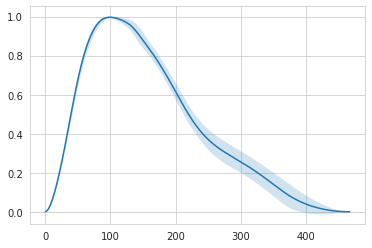

In [85]:
#variance in the test set
timepoints = np.arange(ys.shape[1])
y_mean = y_test.mean(axis=0)
y_std = y_test.std(axis = 0)
print('max std in the data: ', torch.max(y_std))
plt.plot(timepoints, y_mean, '-')
plt.fill_between(timepoints, y_mean - y_std, y_mean + y_std, alpha=0.2)

max std in the data:  tensor(0.0247)


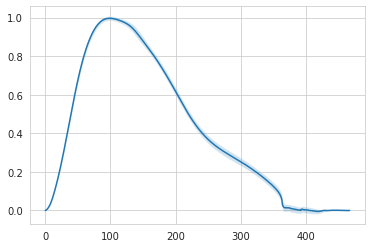

In [86]:
#variance of the model predictions
%matplotlib inline
sns.set_style('whitegrid')
timepoints = np.arange(y_predict.shape[1])
mean = y_predict.mean(axis=0)
std = y_predict.std(axis = 0)
print('max std in the data: ', torch.max(std))
plt.plot(timepoints, mean, '-')
plt.fill_between(timepoints, mean - std, mean + std, alpha=0.2)

Average MSE on the test set is:  0.0023887434508651495


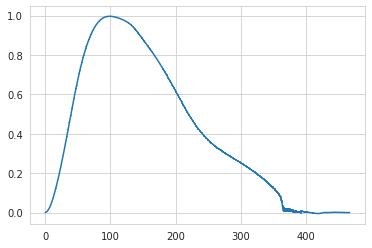

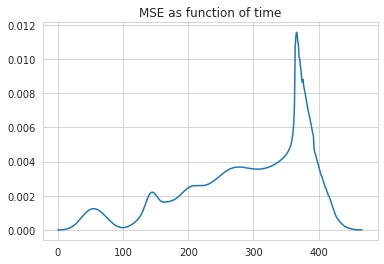

In [87]:
#plot the mean squared error as a function of time
mse = torch.mean((y_test-y_predict)**2, dim = 0)
print('Average MSE on the test set is: ', mse.mean().item())
plt.errorbar(timepoints, mean, yerr=mse)
plt.show()
plt.title('MSE as function of time')
plt.plot(timepoints, mse)

Average relative error on the test set is  0.13598111271858215


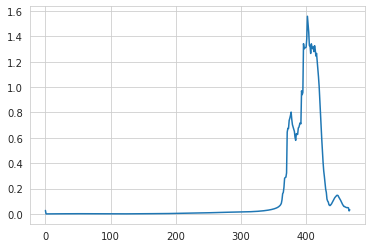

In [88]:
#plot the relative error
rel_err_dim0 = torch.mean((y_test-y_predict)**2/(y_test+1e-8), dim = 0)
print('Average relative error on the test set is ', rel_err_dim0.mean().item())
plt.plot(timepoints, rel_err_dim0)

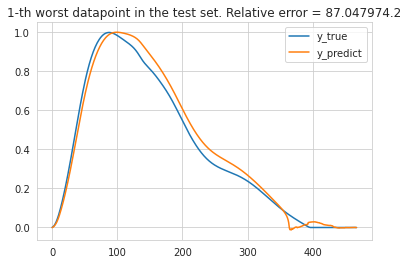

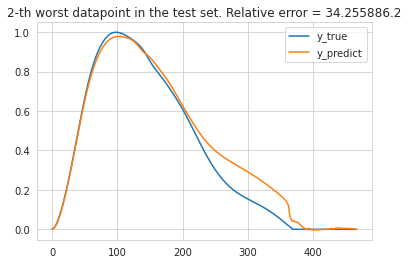

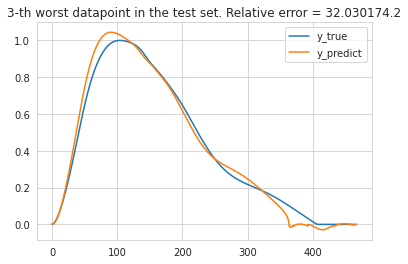

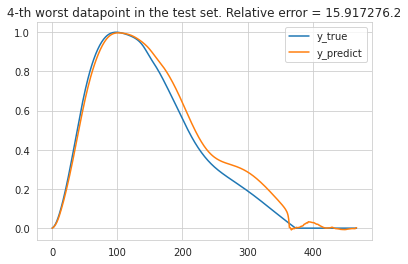

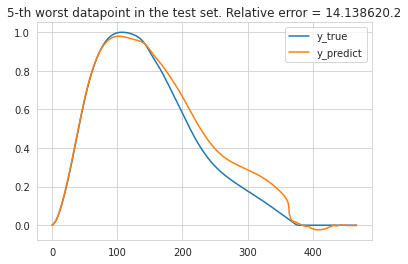

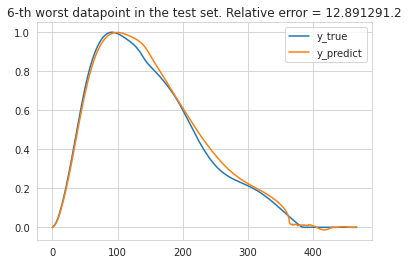

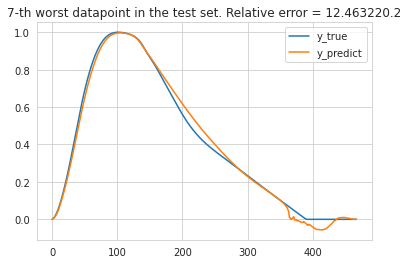

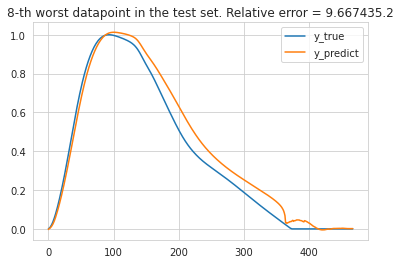

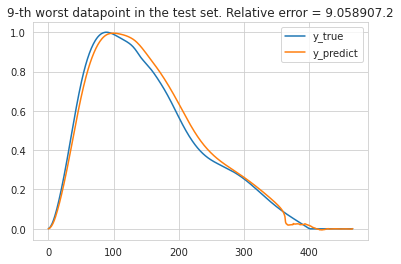

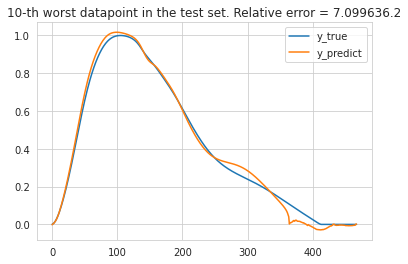

In [89]:
#plot the top10 datapoints with worst relative error
rel_err_dim1 = torch.mean((y_test-y_predict)**2/(y_test+1e-8), dim = 1)
order = torch.argsort(rel_err_dim1)
for i in range(1,11):
    plt.title('%d-th worst datapoint in the test set. Relative error = %f.2'%(i,rel_err_dim1[order][-i]))
    plt.plot(timepoints, y_test[order][-i], label = 'y_true')
    plt.plot(timepoints, y_predict[order][-i], label = 'y_predict')
    plt.legend()
    plt.show()
    

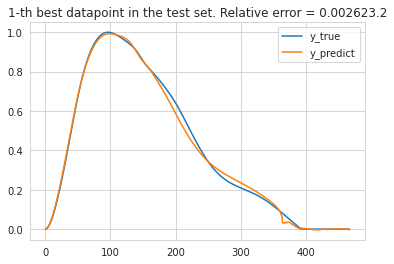

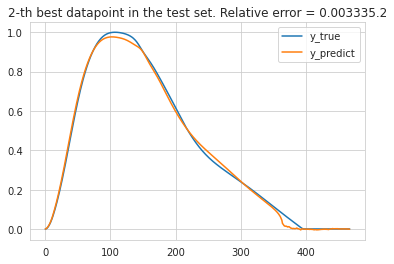

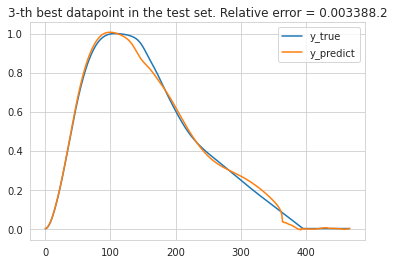

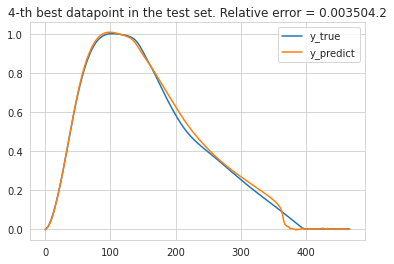

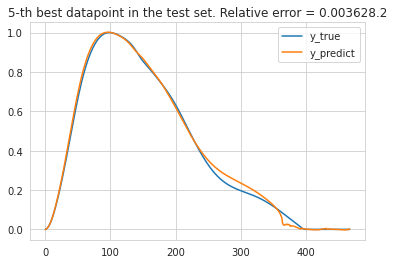

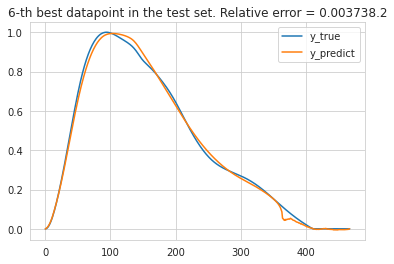

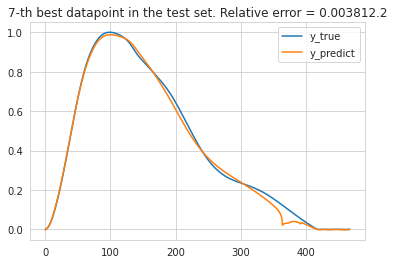

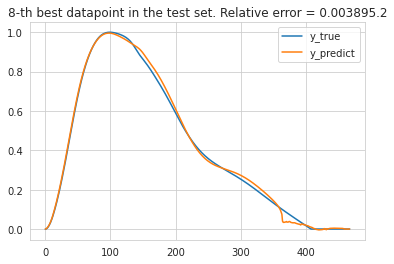

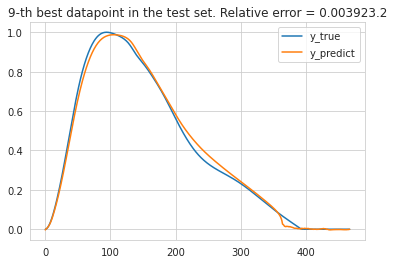

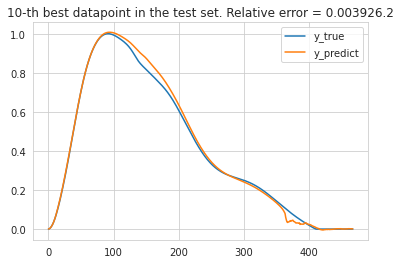

In [90]:
#plot the top10 datapoints with best relative error
for i in range(10):
    plt.title('%d-th best datapoint in the test set. Relative error = %f.2'%(i+1,rel_err_dim1[order][i]))
    plt.plot(timepoints, y_test[order][i], label = 'y_true')
    plt.plot(timepoints, y_predict[order][i], label = 'y_predict')
    plt.legend()
    plt.show()
    

In [33]:
#read literature values of prior
meanfile = '../lit/mean.csv'
stdfile = '../lit/std.csv'
lit_mean = pd.read_csv(meanfile)
lit_std = pd.read_csv(stdfile)
print(lit_mean.head())
print(lit_std.head())

   age    hr    sv  lvet   dia  pwv   mbp
0   25  73.0  66.8   283  36.7  5.9  89.2
1   35  76.3  64.1   284  37.8  6.4  92.8
2   45  77.0  61.3   283  39.0  7.3  96.3
3   55  77.0  58.7   282  40.2  8.0  96.2
4   65  76.3  55.8   282  41.4  8.9  95.4
   age   hr    sv  lvet  dia  pwv  mbp
0   25  9.1  13.1    23  2.6  0.6  6.2
1   35  9.1  12.5    23  2.7  0.8  6.1
2   45  9.0  11.6    23  2.8  0.9  6.1
3   55  9.1  11.1    23  2.9  1.1  6.0
4   65  9.0  10.4    23  3.0  1.3  5.9


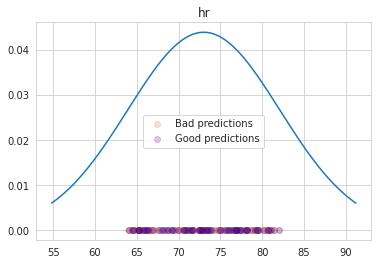

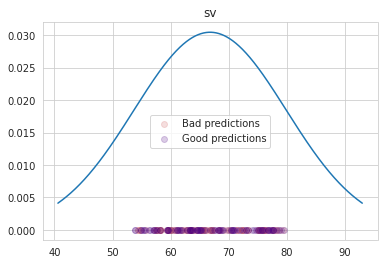

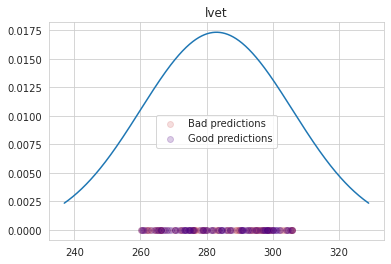

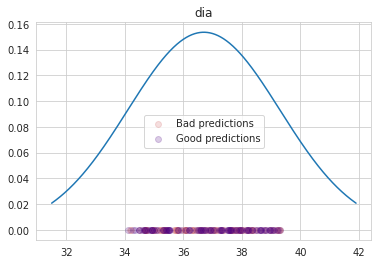

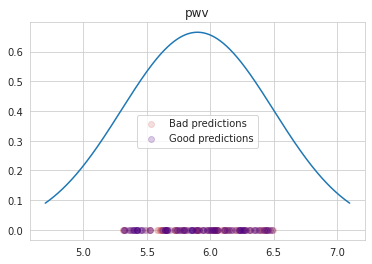

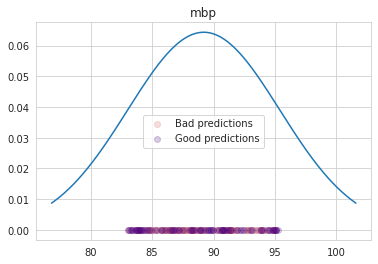

In [34]:
row_mean = lit_mean.loc[lit_mean['age']==25]
row_std = lit_std.loc[lit_std['age']==25]
x_orig = utils.reverse_preprocessing(x_test.data.numpy()[order],filename)
for idx,param in enumerate(list(lit_mean.columns)[1:]):
    plt.title(param)
    mean = row_mean[param]
    std = row_std[param]
    x = np.linspace(mean-2*std, mean+2*std, 1000)
    plt.plot(x, scipy.stats.norm(mean,std).pdf(x))
    bad_x = x_orig[-100:,idx]
    good_x = x_orig[:100,idx]
    plt.scatter(bad_x, np.zeros_like(bad_x), color ='indianred', label = 'Bad predictions', alpha=.2)
    plt.scatter(good_x,np.zeros_like(good_x), color = 'indigo', label = 'Good predictions', alpha=.2)
    plt.legend()
    plt.show()

## We are doing the same analysis for the best model

In [25]:
chkpnt_best['epoch']

NameError: name 'chkpnt_best' is not defined

In [26]:
with torch.no_grad():
    y_predict = best_model(x_test)
y_predict.shape

NameError: name 'best_model' is not defined

max std in the data:  tensor(0.0626)


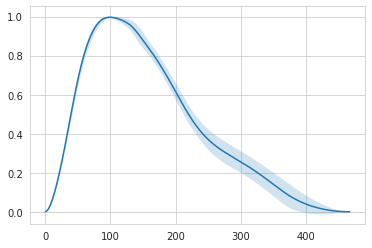

In [16]:
#variance in the test set
timepoints = np.arange(ys.shape[1])
y_mean = y_test.mean(axis=0)
y_std = y_test.std(axis = 0)
print('max std in the data: ', torch.max(y_std))
plt.plot(timepoints, y_mean, '-')
plt.fill_between(timepoints, y_mean - y_std, y_mean + y_std, alpha=0.2)

max std in the data:  tensor(0.0203)


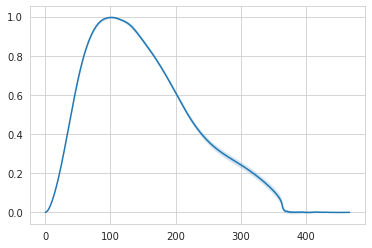

In [17]:
#variance of the model predictions
%matplotlib inline
sns.set_style('whitegrid')
timepoints = np.arange(y_predict.shape[1])
mean = y_predict.mean(axis=0)
std = y_predict.std(axis = 0)
print('max std in the data: ', torch.max(std))
plt.plot(timepoints, mean, '-')
plt.fill_between(timepoints, mean - std, mean + std, alpha=0.2)

Average MSE on the test set is:  0.002360773738473654


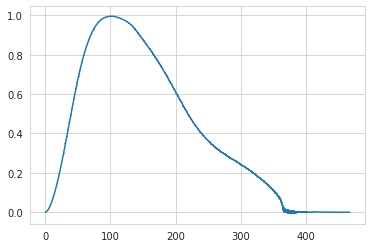

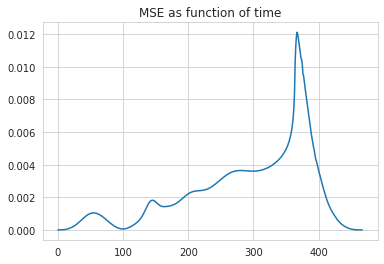

In [18]:
#plot the mean squared error as a function of time
mse = torch.mean((y_test-y_predict)**2, dim = 0)
print('Average MSE on the test set is: ', mse.mean().item())
plt.errorbar(timepoints, mean, yerr=mse)
plt.show()
plt.title('MSE as function of time')
plt.plot(timepoints, mse)

Average relative error on the test set is  0.017771942541003227


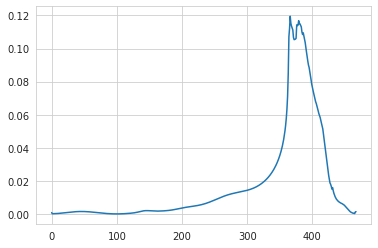

In [19]:
#plot the relative error
rel_err_dim0 = torch.mean((y_test-y_predict)**2/(y_test+1e-4), dim = 0)
print('Average relative error on the test set is ', rel_err_dim0.mean().item())
plt.plot(timepoints, rel_err_dim0)

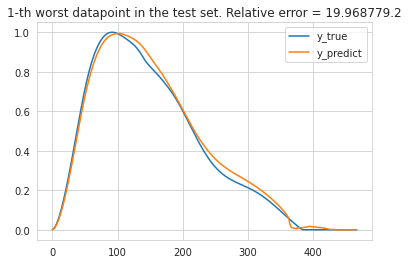

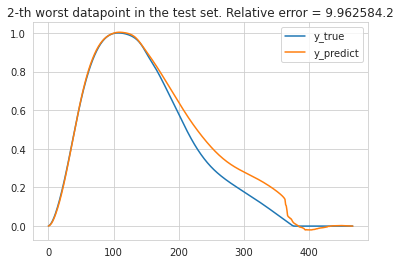

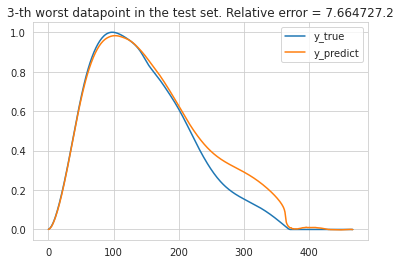

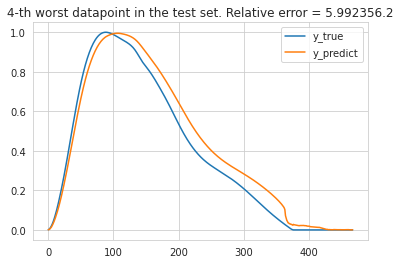

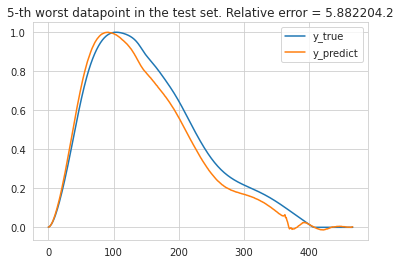

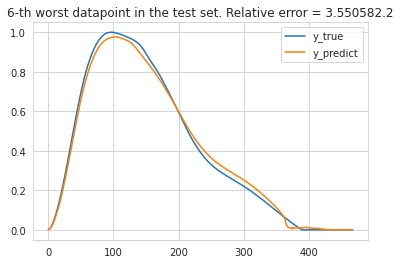

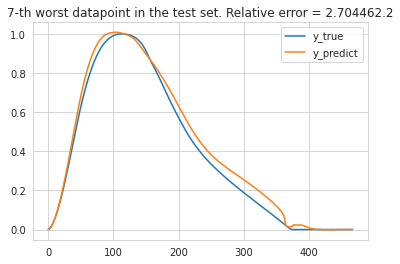

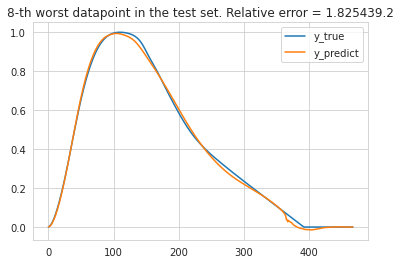

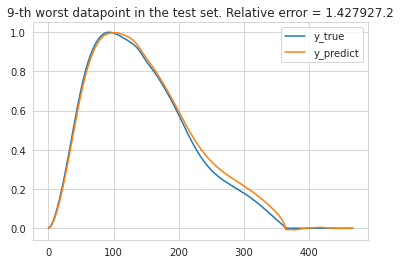

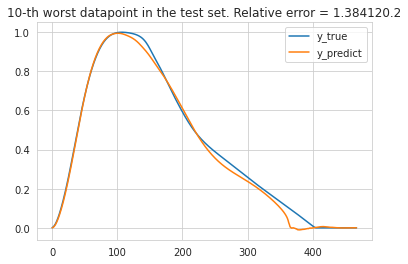

In [20]:
#plot the top10 datapoints with worst relative error
rel_err_dim1 = torch.mean((y_test-y_predict)**2/y_test, dim = 1)
order = torch.argsort(rel_err_dim1)
for i in range(1,11):
    plt.title('%d-th worst datapoint in the test set. Relative error = %f.2'%(i,rel_err_dim1[order][-i]))
    plt.plot(timepoints, y_test[order][-i], label = 'y_true')
    plt.plot(timepoints, y_predict[order][-i], label = 'y_predict')
    plt.legend()
    plt.show()

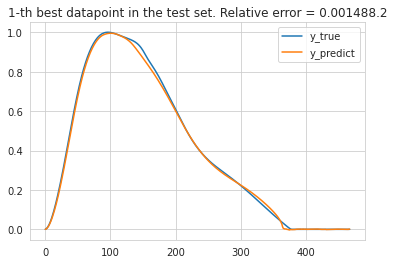

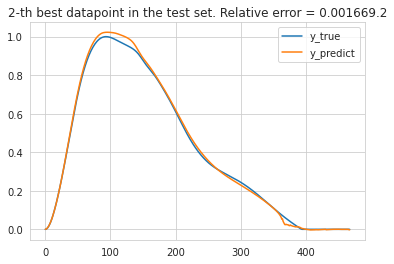

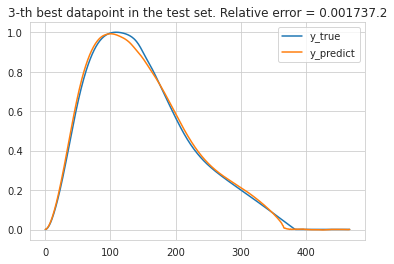

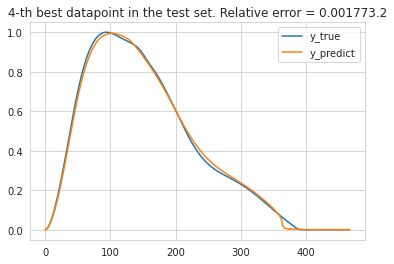

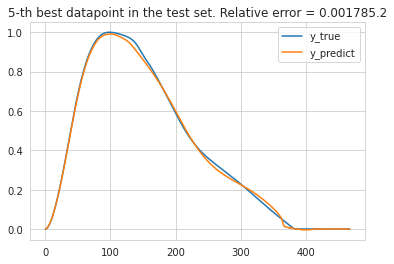

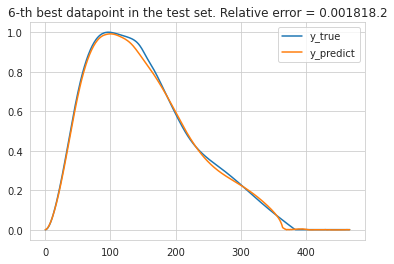

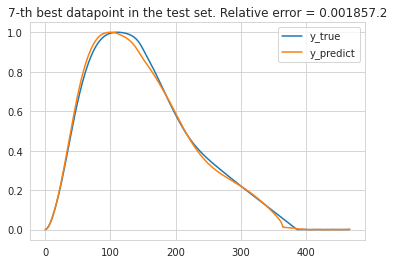

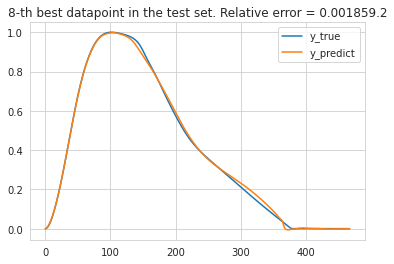

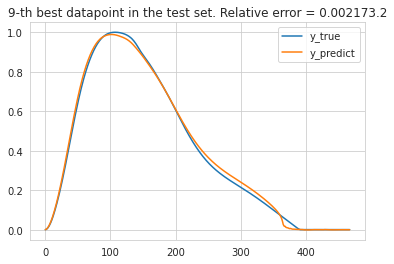

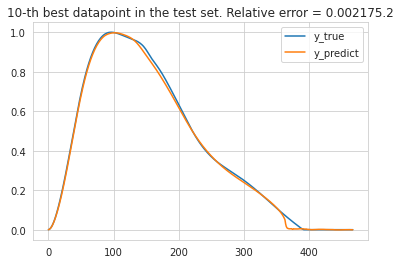

In [21]:
#plot the top10 datapoints with best relative error
for i in range(10):
    plt.title('%d-th best datapoint in the test set. Relative error = %f.2'%(i+1,rel_err_dim1[order][i]))
    plt.plot(timepoints, y_test[order][i], label = 'y_true')
    plt.plot(timepoints, y_predict[order][i], label = 'y_predict')
    plt.legend()
    plt.show()

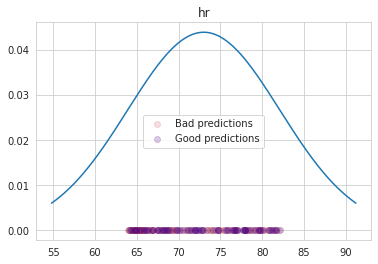

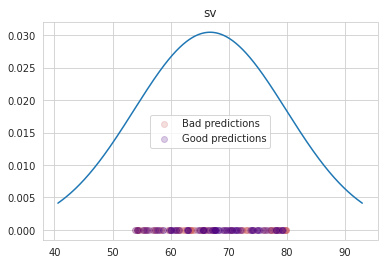

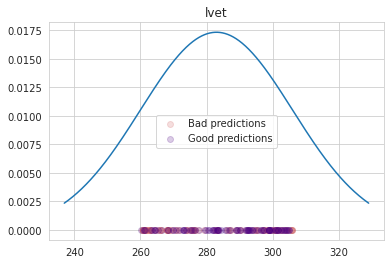

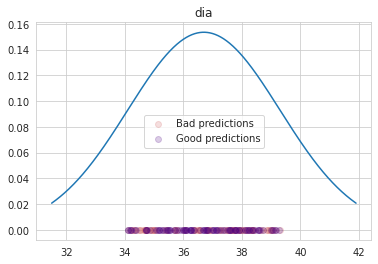

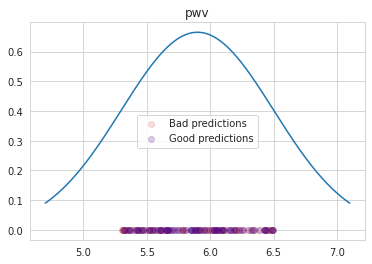

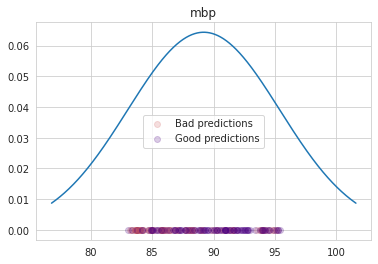

In [22]:
row_mean = lit_mean.loc[lit_mean['age']==25]
row_std = lit_std.loc[lit_std['age']==25]
x_orig = utils.reverse_preprocessing(x_test.data.numpy()[order],filename)
for idx,param in enumerate(list(lit_mean.columns)[1:]):
    plt.title(param)
    mean = row_mean[param]
    std = row_std[param]
    x = np.linspace(mean-2*std, mean+2*std, 1000)
    plt.plot(x, scipy.stats.norm(mean,std).pdf(x))
    bad_x = x_orig[-100:,idx]
    good_x = x_orig[:100,idx]
    plt.scatter(bad_x, np.zeros_like(bad_x), color ='indianred', label = 'Bad predictions', alpha=.2)
    plt.scatter(good_x,np.zeros_like(good_x), color = 'indigo', label = 'Good predictions', alpha=.2)
    plt.legend()
    plt.show()

## To check if our model overfits we also test on the training set

In [23]:
with torch.no_grad():
    y_predict = current_model(x_train)
y_predict.shape

torch.Size([20000, 468])

max std in the data:  tensor(0.0636)


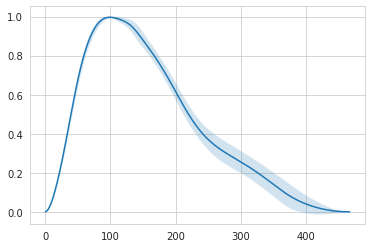

In [24]:
#variance in the training set
timepoints = np.arange(ys.shape[1])
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis = 0)
print('max std in the data: ', torch.max(y_std))
plt.plot(timepoints, y_mean, '-')
plt.fill_between(timepoints, y_mean - y_std, y_mean + y_std, alpha=0.2)

max std in the data:  tensor(0.0678)


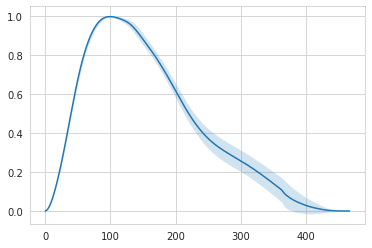

In [25]:
#variance of the model predictions
%matplotlib inline
sns.set_style('whitegrid')
timepoints = np.arange(y_predict.shape[1])
mean = y_predict.mean(axis=0)
std = y_predict.std(axis = 0)
print('max std in the data: ', torch.max(std))
plt.plot(timepoints, mean, '-')
plt.fill_between(timepoints, mean - std, mean + std, alpha=0.2)

Average MSE on the training set is:  0.00035450345603749156


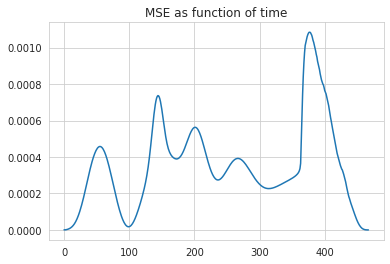

In [26]:
#plot the mean squared error as a function of time
mse = torch.mean((y_train-y_predict)**2, dim = 0)
print('Average MSE on the training set is: ', mse.mean().item())
plt.title('MSE as function of time')
plt.plot(timepoints, mse)

Average relative error on the training set is  0.002207371173426509


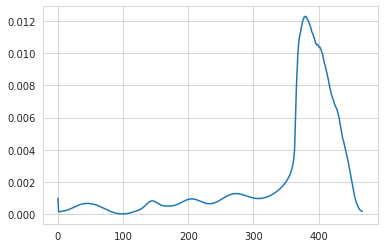

In [27]:
#plot the relative error
rel_err_dim0 = torch.mean((y_train-y_predict)**2/(y_train+1e-4), dim = 0)
print('Average relative error on the training set is ', rel_err_dim0.mean().item())
plt.plot(timepoints, rel_err_dim0)

## Inspect best model on the training set

In [28]:
with torch.no_grad():
    y_predict = best_model(x_train)
y_predict.shape

torch.Size([20000, 468])

max std in the data:  tensor(0.0636)


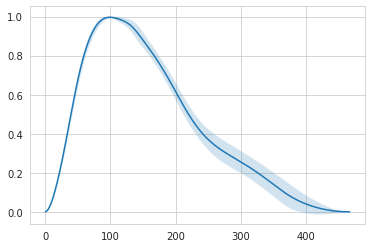

In [29]:
#variance in the training set
timepoints = np.arange(ys.shape[1])
y_mean = y_train.mean(axis=0)
y_std = y_train.std(axis = 0)
print('max std in the data: ', torch.max(y_std))
plt.plot(timepoints, y_mean, '-')
plt.fill_between(timepoints, y_mean - y_std, y_mean + y_std, alpha=0.2)

max std in the data:  tensor(0.0188)


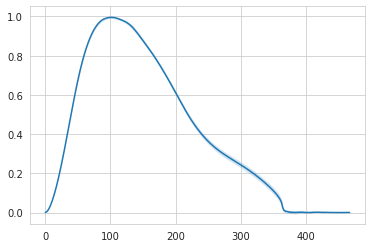

In [30]:
#variance of the model predictions
%matplotlib inline
sns.set_style('whitegrid')
timepoints = np.arange(y_predict.shape[1])
mean = y_predict.mean(axis=0)
std = y_predict.std(axis = 0)
print('max std in the data: ', torch.max(std))
plt.plot(timepoints, mean, '-')
plt.fill_between(timepoints, mean - std, mean + std, alpha=0.2)

Average MSE on the training set is:  0.0022007867228239775


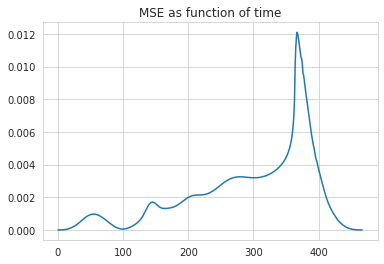

In [31]:
#plot the mean squared error as a function of time
mse = torch.mean((y_train-y_predict)**2, dim = 0)
print('Average MSE on the training set is: ', mse.mean().item())
plt.title('MSE as function of time')
plt.plot(timepoints, mse)

Average relative error on the training set is  0.014104810543358326


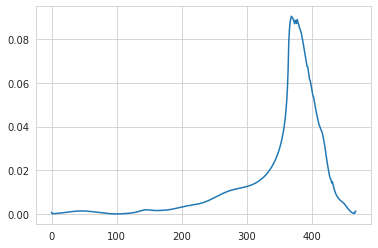

In [32]:
#plot the relative error
rel_err_dim0 = torch.mean((y_train-y_predict)**2/(y_train+1e-4), dim = 0)
print('Average relative error on the training set is ', rel_err_dim0.mean().item())
plt.plot(timepoints, rel_err_dim0)